# Importing required libraries

In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown


# Importing the dataset

##### The dataset has 2 files: `train.csv` and `valid.csv` with a proportion of 70:30 images and a total of 10k images.

**Real:** NVIDIA Research's Flickr-Faces-HQ Dataset. Represented as 1 in dataset.  
**Fake:** Bojan Tunguz's 1 Million Fake Face dataset generated by StyleGAN. Represented as 0 in dataset


In [8]:
train_file_path = os.path.join(os.getcwd(), '..', 'Data', 'train.csv')
valid_file_path = os.path.join(os.getcwd(), '..', 'Data', 'valid.csv')

train_df = pd.read_csv(train_file_path)
valid_df = pd.read_csv(valid_file_path)

In [5]:
pd.concat([train_df.sample(2).assign(Source='train_df'), 
           valid_df.sample(2).assign(Source='valid_df')])

,Unnamed: 0,original_path,id,label,label_str,path,Source
415,35107,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24564,1,real,train/real/24564.jpg,train_df
2887,12210,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,47055,1,real,train/real/47055.jpg,train_df
978,14215,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,50230,1,real,valid/real/50230.jpg,valid_df
292,21774,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11755,1,real,valid/real/11755.jpg,valid_df


#### Updating images path to absolute path from relative for modelling

**From:** train/real/04727.jpg  \
**To:** D:\Git\DeepGuard\Notebooks\\..\Data\train\real\04727.jpg



In [9]:
base_images_path = os.path.join(os.getcwd(), '..', 'Data')

## Replacing '/' in the dataframe with '\'
train_df['path'] = train_df['path'].str.replace('/', '\\')
valid_df['path'] = valid_df['path'].str.replace('/', '\\')

## Adding getcwd() path to dataframe
train_df['path'] = train_df['path'].apply(lambda path: os.path.join(base_images_path, path))
valid_df['path'] = valid_df['path'].apply(lambda path: os.path.join(base_images_path, path))

#### Removing unwanted columns

In [10]:
drop_columns = ['Unnamed: 0', 'original_path', 'id']
train_df.drop(columns=drop_columns, inplace=True)
valid_df.drop(columns=drop_columns, inplace=True)

#### Sampling 3 images from each training and validation

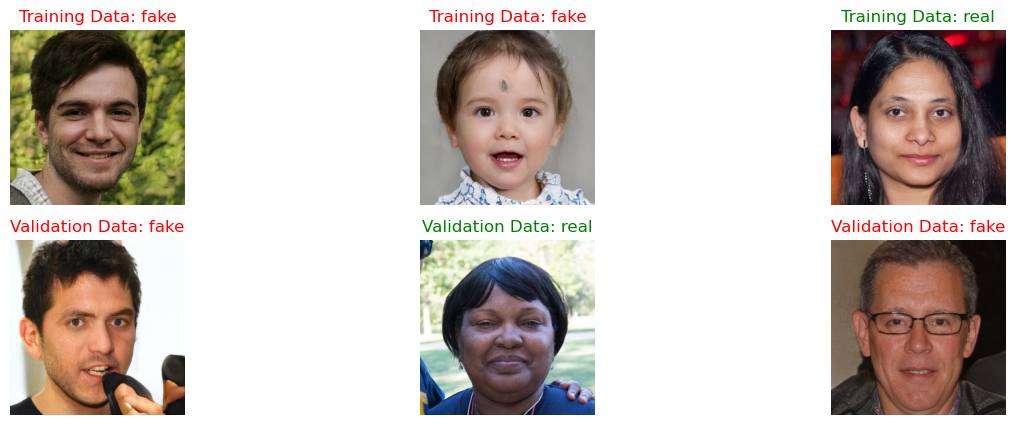

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
sample_images = pd.concat([train_df.sample(3).assign(Source='Training Data'), valid_df.sample(3).assign(Source='Validation Data')])

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    path = row['path']
    label = row['label_str']
    title = row['Source'] + ': ' + label
    
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=12, color='green' if label=='real' else 'red')

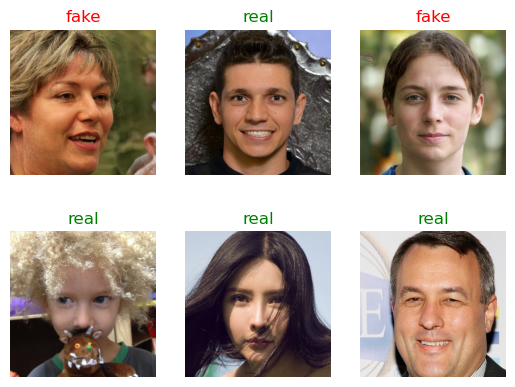

In [132]:
fig, axes = plt.subplots(2, 3)
sample_images = pd.concat([train_df.sample(3).assign(Source='Training Data'), valid_df.sample(3).assign(Source='Validation Data')])

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    path = row['path']
    label = row['label_str']
    title = label
    
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=12, color='green' if label=='real' else 'red')

# Train Test Split with (Train, Validation, Test = 70,10,20)
Using train_df for training and valid_df for validation and test.

**Train_df (70%)**  
 - Training(100%) - 7k images
 
**Valid_df (30%)**: Perform 67-33 split for test and validation
 - Test(67%) - 2k images
 - Validation(33%) - 1k images  

In [33]:
# Initial Dataset
display(Markdown('**Initial Counts before Split**'))
display(pd.concat([train_df['label_str'].value_counts(), valid_df['label_str'].value_counts()], axis=1, keys=['Train', 'Validation']))

#Splitting valid_df into validation and test dataset in 10-20 proportion of total data
validation_df, test_df = train_test_split(valid_df, test_size=0.67, random_state=1000)
display(Markdown('**After Test-Validation Split**'))
display(pd.concat([train_df['label_str'].value_counts(), validation_df['label_str'].value_counts(), test_df['label_str'].value_counts()], axis=1, 
                  keys=['Train', 'Validation', 'Test']))

**Initial Counts before Split**

,Train,Validation
label_str,,
real,3500,1500
fake,3500,1500


**After Test-Validation Split**

,Train,Validation,Test
label_str,,,
real,3500,493,1007
fake,3500,496,1004


In [11]:
# # Train, Val and Test Dataset 
# X_train = train_df['path'].values
# y_train = train_df['label'].values

# X_val = validation_df['path'].values
# y_val = validation_df['label'].values

# X_test = test_df['path'].values
# y_test = test_df['label'].values

## Preprocess - Resize (224*224) & Normalize Pixel Values [0,1]

Occupies too much memory so using ImageDataGenerator to perform these steps during training

In [11]:
# def preprocess_image(image_path, image_size= (224,224)):
#     # Load + Resize
#     img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
#     # image to array
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     # Normalization
#     img_array = img_array / 255.0
#     return img_array

# # preprocess_image(train_df['path'][0], image_size).shape
# image_size = (224,224)

# X_train_processed = [preprocess_image(image_path, image_size) for image_path in X_train]
# X_val_processed = [preprocess_image(image_path, image_size) for image_path in X_val]
# X_test_processed = [preprocess_image(image_path, image_size) for image_path in X_test]

## Augmentation

In [31]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,    # Normalizing pixel values [0,1]
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,    # Normalizing pixel values [0,1]
)

In [34]:
image_size = (224, 224)
batch_size=32

train_augmented_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

valid_augmented_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_augmented_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size, 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)

Found 7000 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.
Found 2011 validated image filenames belonging to 2 classes.


## Define Model Architecture

#### Model 1

In [105]:
model1 = Sequential([                                                  # 224x224x3
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 222x222x32
    MaxPooling2D(pool_size=(2, 2)),                                    # 111x111x32 
    
    Conv2D(64, (3, 3), activation='relu'),                             # 109x109x64
    MaxPooling2D(pool_size=(2, 2)),                                    # 54x54x64
    
    Flatten(),                                                         
    Dense(256, activation='relu'),                                     
    Dropout(0.5),                                                      
    Dense(1, activation='sigmoid')                                     
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

#### Model 2 - Using Batch Normalization

In [1]:
# model2 = Sequential([
#     Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Conv2D(256, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     # Conv2D(512, (3, 3), activation='relu', padding='same'),
#     # BatchNormalization(),
#     # MaxPooling2D(pool_size=(2, 2)),
    
#     # Conv2D(512, (3, 3), activation='relu', padding='same'),
#     # BatchNormalization(),
#     # MaxPooling2D(pool_size=(2, 2)),
    
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     # Dense(256, activation='relu'),
#     # Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])


# model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# model2.summary()

## Training models

In [4]:
def train_gen (model, train_generator, valid_generator, epochs, batch_size):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        batch_size=batch_size
    )

In [106]:
batch_size = 32
epochs=10

history = model1.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/10
219/219 [==============================] - 166s 720ms/step - loss: 0.7139 - accuracy: 0.5254 - val_loss: 0.6813 - val_accuracy: 0.5703
Epoch 2/10
219/219 [==============================] - 71s 324ms/step - loss: 0.6892 - accuracy: 0.5479 - val_loss: 0.6791 - val_accuracy: 0.5753
Epoch 3/10
219/219 [==============================] - 69s 314ms/step - loss: 0.6843 - accuracy: 0.5620 - val_loss: 0.6718 - val_accuracy: 0.6047
Epoch 4/10
219/219 [==============================] - 68s 309ms/step - loss: 0.6802 - accuracy: 0.5753 - val_loss: 0.6646 - val_accuracy: 0.6309
Epoch 5/10
219/219 [==============================] - 72s 330ms/step - loss: 0.6789 - accuracy: 0.5763 - val_loss: 0.6567 - val_accuracy: 0.6512
Epoch 6/10
219/219 [==============================] - 71s 324ms/step - loss: 0.6744 - accuracy: 0.5790 - val_loss: 0.6550 - val_accuracy: 0.6593
Epoch 7/10
219/219 [==============================] - 72s 330ms/step - loss: 0.6712 - accuracy: 0.5904 - val_loss: 0.6469 - val_a

In [2]:
# batch_size = 32
# epochs=10

# history2 = model2.fit(
#     train_augmented_generator,
#     steps_per_epoch=len(train_augmented_generator),
#     epochs=epochs,
#     validation_data=valid_augmented_generator,
#     validation_steps=len(valid_augmented_generator),
#     batch_size=batch_size
# )
# # train_gen(model2, train_augmented_generator, valid_augmented_generator, epochs, batch_size)

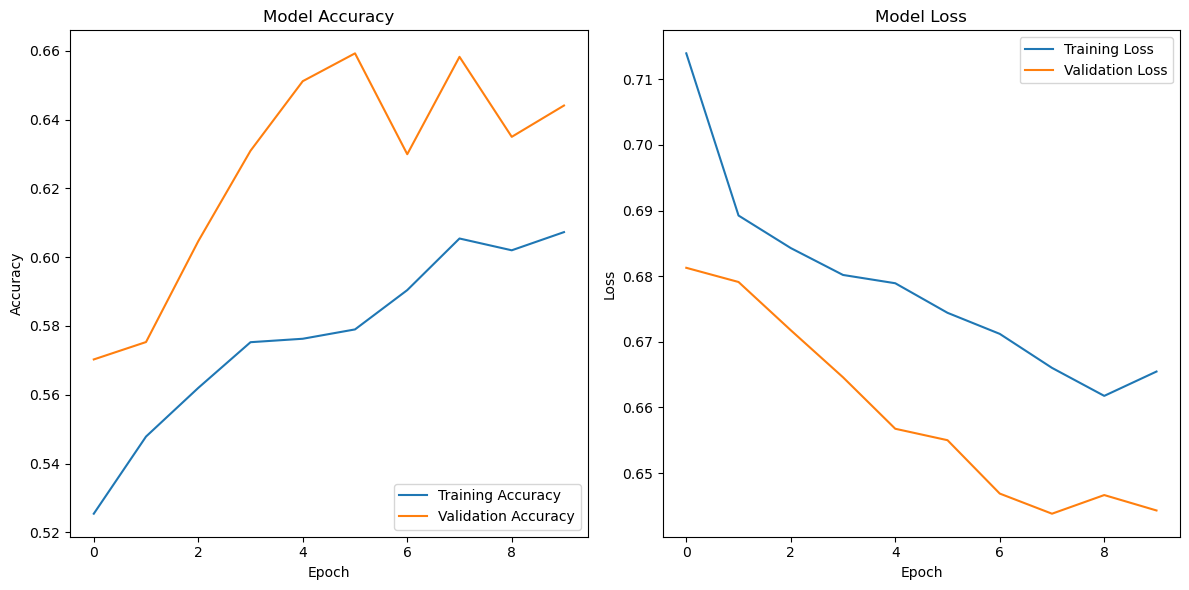

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Test

In [108]:
def test_predictions_gen (model, test_generator):
    y_pred = model.predict(test_augmented_generator)    
    return y_pred

def test_evaluate_gen (model, test_generator):
    loss, accuracy = model.evaluate(test_augmented_generator, steps=len(test_augmented_generator))
    return loss, accuracy
    

In [113]:
# y_pred1 = test_predictions_gen(model1, test_augmented_generator)
loss, accuracy = test_evaluate_gen(model1, test_augmented_generator)
print("Test Accuracy:", accuracy)


63/63 [==============================] - 7s 115ms/step - loss: 0.6591 - accuracy: 0.6271
Test Accuracy: 0.6270512342453003


array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

Confusion Matrix:
[[682 322]
 [428 579]]


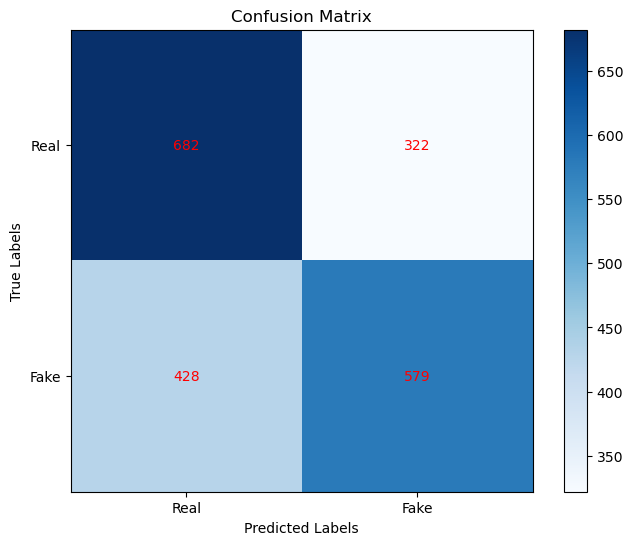

In [117]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate confusion matrix
y_pred1 = np.round(y_pred1).astype(int)
y_test = test_df['label'].values

conf_matrix = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.yticks([0, 1], ['Real', 'Fake'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')
plt.show()

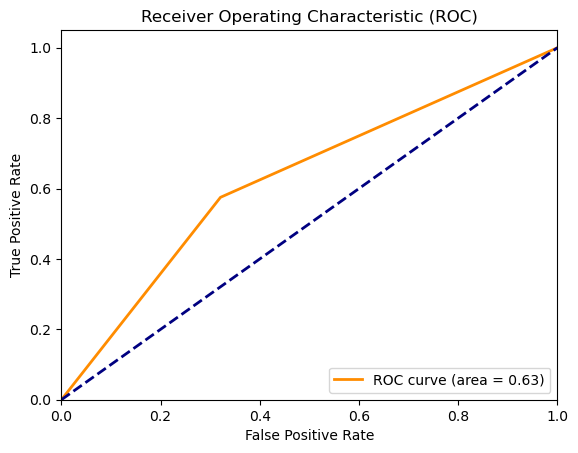

In [119]:
# Generate ROC curve and compute AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [19]:
%whos

Variable                    Type                  Data/Info
-----------------------------------------------------------
BatchNormalization          type                  <class 'keras.layers.norm<...>tion.BatchNormalization'>
Conv2D                      type                  <class 'keras.layers.conv<...>olutional.conv2d.Conv2D'>
Dense                       type                  <class 'keras.layers.core.dense.Dense'>
Dropout                     type                  <class 'keras.layers.regu<...>ization.dropout.Dropout'>
Flatten                     type                  <class 'keras.layers.reshaping.flatten.Flatten'>
Image                       module                <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
Markdown                    type                  <class 'IPython.core.display.Markdown'>
MaxPooling2D                type                  <class 'keras.layers.pool<...>_pooling2d.MaxPooling2D'>
Sequential                  type                  <class 'keras.engine.

In [50]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

# Check if cuDNN is enabled
if tf.test.is_built_with_cuda():
    print("cuDNN is enabled.")
else:
    print("cuDNN is not enabled.")

TensorFlow version: 2.10.0
GPU is available.
cuDNN is enabled.


In [ ]:
# %whos
import resource

# Define a function to get memory usage of a variable
def get_size(variable):
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

# Print memory usage of a specific variable
print("Memory usage of variable_name:", get_size(variable_name))
